Currently evaluating -------------------------------:
Thursday, 03. October 2024 12:29AM
CPUs: 14, GPUs: 1 on LAPTOP-HS456NH3.
GPU : NVIDIA GeForce RTX 2050
Files already downloaded and verified
Files already downloaded and verified
Model initialized with random key 0.


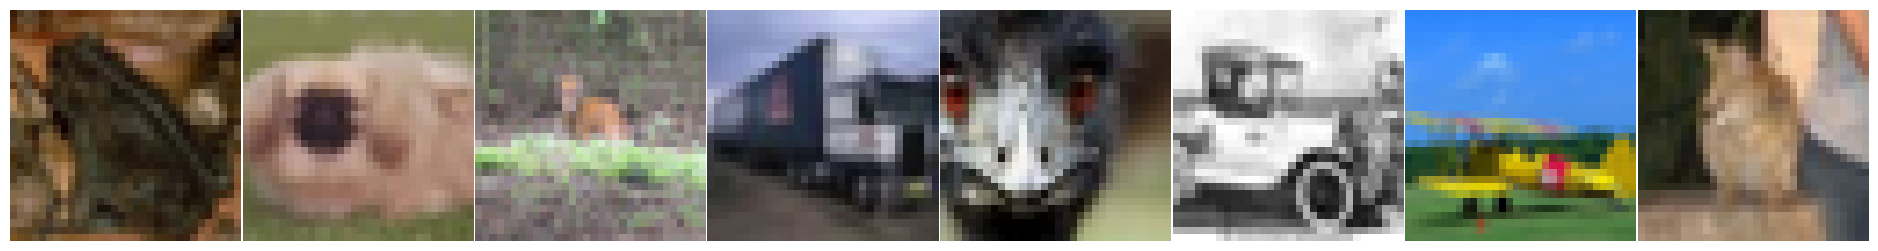

['frog', 'dog', 'deer', 'truck', 'bird', 'automobile', 'airplane', 'cat']
Num of Parameters: 2904970


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from defense import defended_gradients
import torch.nn as nn
from PIL import Image

arch = 'ConvNet32'#ResNet32'#
num_images = 8
trained_model = False
idx=30

import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('CIFAR10', defs)

model, _ = inversefed.construct_model(arch, num_classes=10, num_channels=3,seed=0)
model.to(**setup)
if trained_model:
    epochs = 120
    file = f'{arch}_{epochs}.pth'
    try:
        model.load_state_dict(torch.load(f'models/{file}'))
    except FileNotFoundError:
        inversefed.train(model, loss_fn, trainloader, validloader, defs, setup=setup)
        torch.save(model.state_dict(), f'models/{file}')
model.eval();

dm = torch.as_tensor(inversefed.consts.cifar10_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.cifar10_std, **setup)[:, None, None]
def plot(tensor, filepath=None, title=None):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    
    if tensor.shape[0] == 1:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(tensor[0].permute(1, 2, 0).cpu())
        ax.axis('off')
    else:
        # Set the figure size based on the number of images and their size
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(tensor.shape[0] * 3, 3))
        if tensor.shape[0] == 1:
            axes = [axes]  # make axes iterable
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu())
            axes[i].axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        
    if title is not None:
        plt.title(title)
    
    if filepath is not None:
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0)
        
    
    plt.show()
    
if num_images == 1:
    ground_truth_image = torch.as_tensor(np.array(Image.open("auto.jpg").resize((32, 32), Image.BICUBIC)) / 255, 
                                         **setup)
    ground_truth = ground_truth_image.permute(2, 0, 1).sub(dm).div(ds).unsqueeze(0).contiguous()
    labels = torch.as_tensor((1,), device=setup['device'])
else:
    ground_truth, labels = [], []
    # idx = 30 # choosen randomly ... just whatever you want
    while len(labels) < num_images:
        img, label = validloader.dataset[idx]
        idx += 1
        if label not in labels:
            labels.append(torch.as_tensor((label,), device=setup['device']))
            ground_truth.append(img.to(**setup))
    ground_truth = torch.stack(ground_truth)
    labels = torch.cat(labels)
    
plot(ground_truth);
print([validloader.dataset.classes[l] for l in labels]);

print('Num of Parameters:',sum([torch.numel(p) for p in model.parameters()]))

In [5]:
defense='prune'
not_unique_labels=True
clipping_threshold=0.5
num_images = 2

for noise_scale in [0.6]:
    for idx_start in [1,3,5,7]:
        for num_samples in [10]: #Num samples for random sketching
            for defense_type in ['ours','default']:
                idx=idx_start
                model, _ = inversefed.construct_model(arch, num_classes=10, num_channels=3,seed=0)
                model.to(**setup)
                model.eval()


                if num_images == 1:
                    ground_truth_image = torch.as_tensor(np.array(Image.open("auto.jpg").resize((32, 32), Image.BICUBIC)) / 255, 
                                                         **setup)
                    ground_truth = ground_truth_image.permute(2, 0, 1).sub(dm).div(ds).unsqueeze(0).contiguous()
                    labels = torch.as_tensor((1,), device=setup['device'])
                else:
                    ground_truth, labels = [], []
                    # idx = 30 # choosen randomly ... just whatever you want
                    while len(labels) < num_images:
                        img, label = validloader.dataset[idx]
                        idx += 1
                        if (label not in labels) or not_unique_labels:
                            labels.append(torch.as_tensor((label,), device=setup['device']))
                            ground_truth.append(img.to(**setup))
                    ground_truth = torch.stack(ground_truth)
                    labels = torch.cat(labels)

                print(f'\n\n\n\n___^^^___noise_scale:{noise_scale}, defense_method:{defense_type}, num_samples:{num_samples}___^^^___')
                model.zero_grad()
                target_loss, _, _ = loss_fn(model(ground_truth), labels)
                input_gradient = torch.autograd.grad(target_loss, model.parameters())
                input_gradient = [grad.detach() for grad in input_gradient]

                model.zero_grad()
                input_gradient = defended_gradients(model,ground_truth,labels,lambda x,y: loss_fn(x,y)[0],
                                                    noise_scale=noise_scale,
                                                    defense=defense,
                                                    defense_type=defense_type,
                                                    num_samples=num_samples,
                                                    layerwise=False,
                                                    clipping_threshold=clipping_threshold)

                config = dict(signed=True,
                              boxed=True,
                              cost_fn='sim', #l1,l2,max,sim,local default=sim
                              indices='def',
                              weights='equal',
                              lr=0.2,
                              optim='adam', #adam,sgd,LBFGS
                              restarts=1,
                              max_iterations=1000,
                              total_variation=1e-6,
                              init='randn',
                              filter='none',
                              lr_decay=True,
                              scoring_choice='loss')

                torch.manual_seed(0) #To Enforce same starting point

                rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=num_images)
                output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 32, 32))

                test_mse = (output.detach() - ground_truth).pow(2).mean()
                feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
                test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)

                with open('data.txt', 'a') as file:
                    file.write(f"loss: {stats['opt']:2.4f}, MSE: {test_mse:2.4f}, PSNR: {test_psnr:4.2f}, FMSE: {feat_mse:2.4e}, k: {noise_scale}, Defense type: {defense_type}, Num_Samples: {num_samples}, Defense: {defense}, idx:{idx_start}\n")


Model initialized with random key 0.




___^^^___noise_scale:0.6, defense_method:ours, num_samples:10___^^^___
It: 0. Rec. loss: 0.0086.
Recovery interrupted manually in iteration 166!
Choosing optimal result ...
Optimal result score: 0.0085
Total time: 5.491022109985352.
Model initialized with random key 0.




___^^^___noise_scale:0.6, defense_method:default, num_samples:10___^^^___
It: 0. Rec. loss: 0.0057.


It: 0. Rec. loss: 0.0184.
It: 500. Rec. loss: 0.0129.
It: 999. Rec. loss: 0.0150.
Choosing optimal result ...
Optimal result score: 0.0150
Total time: 41.46497464179993.


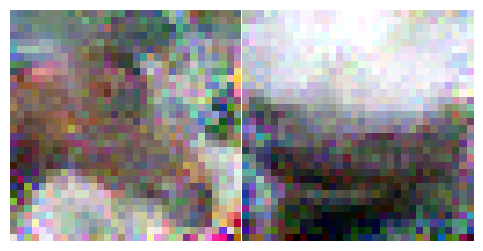

Rec. loss: 0.0150 | MSE: 0.2539 | PSNR: 18.03 | FMSE: 1.8250e-07 |


In [20]:


model.zero_grad()
model.eval()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]

model.zero_grad()
input_gradient = defended_gradients(model,ground_truth,labels,lambda x,y: loss_fn(x,y)[0],
                                    noise_scale=0.1,
                                    defense='prune',
                                    defense_type='ours',
                                    num_samples=10,
                                    layerwise=False,
                                    clipping_threshold=0.5)


config = dict(signed=True,
              boxed=True,
              cost_fn='sim', #l1,l2,max,sim,local default=sim
              indices='def',
              weights='equal',
              lr=0.2,
              optim='adam', #adam,sgd,LBFGS
              restarts=1,
              max_iterations=1000,
              total_variation=1e-6,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

torch.manual_seed(0)#To Enforce same starting point

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=num_images)
output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 32, 32))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)

# plot(output,filepath='prund_ours_0.1.pdf')
plot(output,filepath='prune_ours_0.15.pdf')

print(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} | PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |")